# Transfer Learning for Computer Vision Tutorial
**Extended from [code](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by [Sasank Chilamkurthy](https://chsasank.github.io).**  
License: BSD.

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at the [CS231N notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes:

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




### Running notes
If you are running this in Google Colab, be sure to change the runtime to GPU by clicking `Runtime > Change runtime type` and selecting "GPU" from the dropdown menu.

### Import relevant packages

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

## Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the
data.

The problem we're going to solve today is to train a model to classify
present and future **Israeli politicians**.  
We have about ~100 training images for each of our 9 politicians, automatically scraped from the first page of the Google Images Search without manual review.  
Usually, this is a very small dataset to generalize upon, if trained from scratch (or is it? We'll soon test this ourselves!). Since we are using transfer learning, we should be able to generalize reasonably well.

In [5]:
# Create a folder for our data
# The ! prefix runs this as a shell command
!mkdir data
!mkdir data/israeli_politicians

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/israeli_politicians’: File exists


In [6]:
# Download our dataset and extract it
import requests
from zipfile import ZipFile

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

In [7]:
# On Linux machines, the following simpler code can be used instead
# !wget https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true
# !unzip israeli_politicians.zip -d data/israeli_politicians/

### Dataset Review
At this stage, we suggest that you review your given data and get to know it better.  
Try to look for things that might interfere with its ability to learn and generalize.

### Datasets definition
PyTorch uses DataLoaders to define datasets. We'll create 2 data loaders, `train` and `val` (for validation).  
Our dataset was already split into different folders for these - as you can see under the "Files" menu on the left of the Colab.

In [8]:
# Define transformations that resize the images to 256x256, and normalize them. 
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
size = 128
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]),
    'val': transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}



In [9]:
data_dir = r'./data/israeli_politicians/'

# Create a dictionary of train and val datasets from images in folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

A data loader wraps an iterable around the Dataset to enable easy access to the samples. It combines a dataset and a sampler.

In [10]:
batch_size = 16
num_workers = 16

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size,
                                          shuffle=False, num_workers=num_workers)
  }

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_sizes: ', dataset_sizes)

class_names = image_datasets['train'].classes
print('class_names:', class_names)

dataset_sizes:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']


In [12]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Datasets and Dataloaders
Let's examine the dataloaders and datasets and learn more about their attributes and functions.  

In [13]:
train_dataloader = dataloaders['train']

In Colab or Jupyter notebook, if we type  `train_dataloader.` and wait, we'd see a drop-down with the object attributes and functions.  

`train_dataloader.dataset.samples` contains the filenames + true labels (0 to 8 for our 9 classes).  
`train_dataloader.dataset.classes` contains the class names in order.  
`train_dataloader.dataset.class_to_idx` contains a map from a class name to the integer that represents it.

In [14]:
train_dataloader.dataset.class_to_idx

{'ayelet_shaked': 0,
 'benjamin_netanyahu': 1,
 'benny_gantz': 2,
 'danny_danon': 3,
 'gideon_saar': 4,
 'kostya_kilimnik': 5,
 'naftali_bennett': 6,
 'ofir_akunis': 7,
 'yair_lapid': 8}

### Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



In [15]:
# A helper function to show an image from a tensor. We need to restore it to the original dynamic range before normalization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [16]:
# Get a batch of training data - the data loader is a generator
inputs, classes = next(iter(dataloaders['train']))

To map it to the class names, we can run:

In [17]:
[class_names[c] for c in classes]

['benjamin_netanyahu',
 'benjamin_netanyahu',
 'benjamin_netanyahu',
 'benjamin_netanyahu',
 'ayelet_shaked',
 'ayelet_shaked',
 'ofir_akunis',
 'ofir_akunis',
 'ofir_akunis',
 'ayelet_shaked',
 'ofir_akunis',
 'benjamin_netanyahu',
 'benjamin_netanyahu',
 'ayelet_shaked',
 'benjamin_netanyahu',
 'danny_danon']

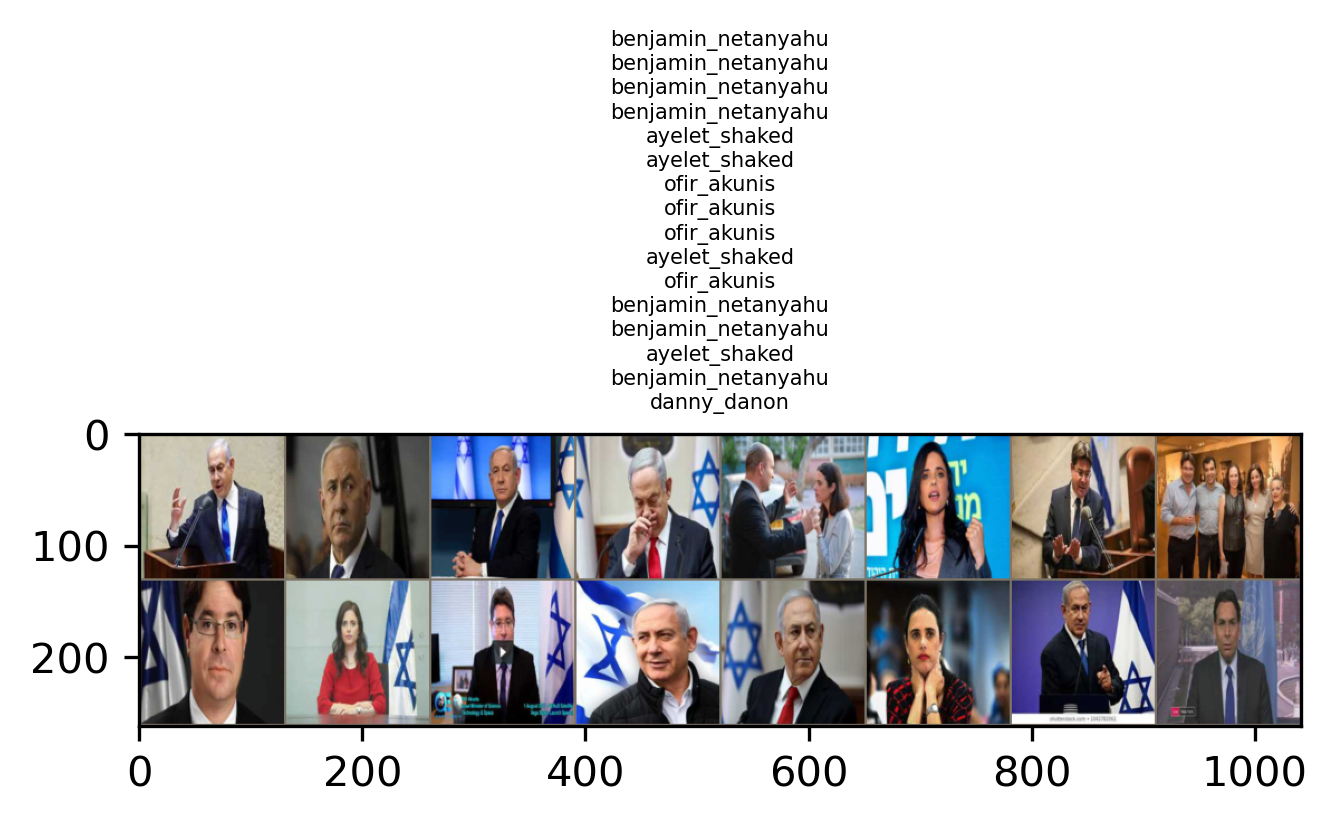

In [18]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

imshow(out, title='\n'.join([class_names[x] for x in classes]))

### Using a pretrained model
Let's load a model pretrained on ImageNet, and use it for our task.  
We will use the VGG16 network, that won the ImageNet Challenge in 2016.

The first time we load the model, it will be downloaded locally, and then cached for the future.

In [19]:
class UnetEncoder(nn.Module):
    def __init__(self,model):
        super(UnetEncoder, self).__init__()
        self.l0 = model.inc
        self.l1 = model.down1
        self.l2 = model.down2
        self.l3 = model.down3
        self.l4 = model.down4
#         self.l5 = nn.Conv2d(1024,512, kernel_size=(1, 1), stride=(1, 1))
        self.softmax = nn.LogSoftmax(dim=-1)
        self.fc = nn.Linear(in_features=65536, out_features=9)
        


    def forward(self, x):
        x = self.l0(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = torch.flatten(x,1)
#         if self.fc is None:
#             print(x.size(1))
#             self.fc = nn.Linear(x.size(1), 9)
        x = self.fc(x)
    
        return self.softmax(x)
    
unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=False, scale=1.0)
unet.outc.conv = nn.Conv2d(64,3, kernel_size=(1, 1), stride=(1, 1))
unet.inc.double_conv[0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = unet


Using cache found in /home/ec2-user/.cache/torch/hub/milesial_Pytorch-UNet_master


In [20]:
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4)

In [21]:
# We load a pretrain model with its weights. Alternatively, one might want to only load the model architecture.

PATH = 'model_weights_unet_gray_img1.pth'
model.load_state_dict(torch.load(PATH))

#take only the encoder
model = UnetEncoder(model)
model.eval()

UnetEncoder(
  (l0): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (l1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [22]:
!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

Next, we define the loss, optimizer and LR scheduler.

In [23]:
# If a GPU is available, make the model use it
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.001 and momentum
# Momentum simulates the corase of a heavy ball, and keeps moving in the direction of the previous gradient along with the new gradient. 
# Empirically it is known to show better convergence. We will learn about it in future lessons.
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
# optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

num_epochs = 10

Let's use 4 GPUs!


Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [24]:
import pandas as pd
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 

                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu().detach().numpy())
            else:#val
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.cpu().detach().numpy())          

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    df = pd.DataFrame({'train_loss':train_loss,
                                   'train_acc':train_acc,
                                   'val_loss':val_loss,
                                   'val_acc':val_acc
                                   })
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, df

In [25]:
model, df_convergence = train_model(model, 
                       dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.3303 Acc: 0.2153
val Loss: 2.3762 Acc: 0.2265

Epoch 1/9
----------
train Loss: 2.2799 Acc: 0.2734
val Loss: 2.3438 Acc: 0.2564

Epoch 2/9
----------
train Loss: 2.2828 Acc: 0.2745
val Loss: 2.3153 Acc: 0.3034

Epoch 3/9
----------
train Loss: 2.2258 Acc: 0.3079
val Loss: 2.4351 Acc: 0.2137

Epoch 4/9
----------
train Loss: 2.0832 Acc: 0.3262
val Loss: 2.3128 Acc: 0.2607

Epoch 5/9
----------
train Loss: 1.6528 Acc: 0.4273
val Loss: 1.9204 Acc: 0.3419

Epoch 6/9
----------
train Loss: 1.5798 Acc: 0.4575
val Loss: 1.8918 Acc: 0.3718

Epoch 7/9
----------
train Loss: 1.5447 Acc: 0.4586
val Loss: 1.8881 Acc: 0.3974

Epoch 8/9
----------
train Loss: 1.5413 Acc: 0.4639
val Loss: 1.9224 Acc: 0.3761

Epoch 9/9
----------
train Loss: 1.5438 Acc: 0.4661
val Loss: 1.8249 Acc: 0.4060

Training complete in 1m 1s
Best val Acc: 0.405983


In [26]:
inputs, labels = next(iter(dataloaders['train']))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)

tensor([[[[ 0.4508,  0.4337,  0.4166,  ...,  2.0777,  2.0605,  2.0434],
          [ 0.4679,  0.4508,  0.4337,  ...,  2.1119,  2.0434,  1.9920],
          [ 0.4851,  0.4679,  0.4508,  ...,  2.0777,  1.9749,  1.8893],
          ...,
          [-1.7754, -1.7754, -1.7754,  ..., -1.8268, -1.7925, -1.2445],
          [-1.8439, -1.8439, -1.8439,  ..., -1.8953, -1.8439, -1.3815],
          [-1.1932, -1.1932, -1.1932,  ..., -1.2617, -1.2274, -0.9192]],

         [[ 0.5728,  0.5553,  0.5378,  ...,  2.2535,  2.2885,  2.3060],
          [ 0.5903,  0.5728,  0.5553,  ...,  2.2710,  2.2360,  2.2010],
          [ 0.6078,  0.5903,  0.5728,  ...,  2.2185,  2.1310,  2.0784],
          ...,
          [-1.6506, -1.6506, -1.6506,  ..., -1.7031, -1.6856, -1.1253],
          [-1.6856, -1.6856, -1.6856,  ..., -1.7556, -1.6856, -1.2304],
          [-1.0203, -1.0203, -1.0203,  ..., -1.0903, -1.0553, -0.7577]],

         [[-0.0092, -0.0267, -0.0441,  ...,  1.8557,  1.5594,  1.3677],
          [ 0.0082, -0.0092, -

## Task 1: Plot model convergence
Adapt the code above to plot the loss and the accuracy every epoch. Show both the training and the validation performance.  
Does our model overfit?  
Do you have suggestions following these graphs? 

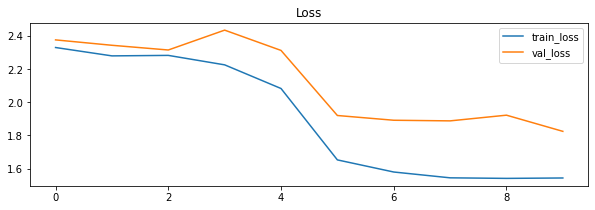

In [28]:
import pandas as pd

fig = plt.figure(figsize=(10,3))
plt.title('Loss')
plt.plot(df_convergence[['train_loss','val_loss']])
plt.legend(['train_loss','val_loss'])

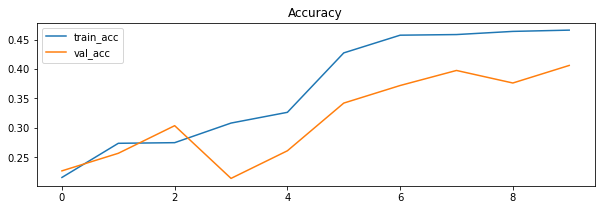

In [29]:
fig = plt.figure(figsize=(10,3))
plt.title('Accuracy')
plt.plot(df_convergence[['train_acc','val_acc']])
plt.legend(['train_acc','val_acc'])

In [30]:
#It seems that the model is overfitting since the training loss is still 
#decreasing while the validation loss does not. (in some of the cases i ran then code, it even stop improving)

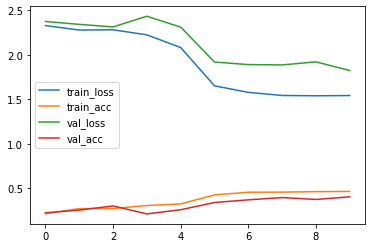

In [31]:
plt.plot(df_convergence)
plt.legend(df_convergence.columns)

## Task 2: Evaluate the model performance
Write code that shows the performance of our model.  
Show the classification report and the confusion matrix.  

What can you say about the model so far?  
Can you suggest a few ideas to improve it?

In [32]:
phase = 'val'

from sklearn.metrics import classification_report
val_results = []
for i, (inputs, labels) in enumerate(dataloaders[phase]):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    
    proba, preds = torch.max(torch.nn.functional.softmax(outputs, dim=1), 1)
    val_results.append([
                        preds.cpu().detach().numpy(),
                        proba.cpu().detach().numpy(),
                        inputs.cpu().detach().numpy(),
                        ])
df_val = pd.DataFrame(dataloaders[phase].dataset.samples, columns=['image_path','label'])

df_val['predicted'] = [item for sublist in val_results for item in sublist[0]]
df_val['pred_proba'] = [item for sublist in val_results for item in sublist[1]]
df_val['img_rep'] = [item for sublist in val_results for item in sublist[2]]
df_val.head()

,image_path,label,predicted,pred_proba,img_rep
0,./data/israeli_politicians/val/ayelet_shaked/i...,0,1,0.446921,"[[[-0.81642264, -0.79929787, -0.7650484, -0.74..."
1,./data/israeli_politicians/val/ayelet_shaked/i...,0,0,0.931141,"[[[-2.117904, -2.117904, -2.117904, -2.117904,..."
2,./data/israeli_politicians/val/ayelet_shaked/i...,0,7,0.334472,"[[[-1.9466565, -1.9637812, -1.9980307, -2.0151..."
3,./data/israeli_politicians/val/ayelet_shaked/i...,0,0,0.910917,"[[[-2.117904, -2.117904, -2.117904, -2.117904,..."
4,./data/israeli_politicians/val/ayelet_shaked/i...,0,0,0.446940,"[[[-0.23418105, -0.2170563, -0.18280679, -0.16..."


In [33]:
my_dict = dataloaders[phase].dataset.class_to_idx
my_dict2 = {y:x for x,y in my_dict.items()}
label_names = [my_dict2[x] for x in df_val.label.values]
df_val['label'] = label_names
prediction_names = [my_dict2[x] for x in df_val.predicted.values]
df_val['predicted'] = prediction_names
df_val.head()

,image_path,label,predicted,pred_proba,img_rep
0,./data/israeli_politicians/val/ayelet_shaked/i...,ayelet_shaked,benjamin_netanyahu,0.446921,"[[[-0.81642264, -0.79929787, -0.7650484, -0.74..."
1,./data/israeli_politicians/val/ayelet_shaked/i...,ayelet_shaked,ayelet_shaked,0.931141,"[[[-2.117904, -2.117904, -2.117904, -2.117904,..."
2,./data/israeli_politicians/val/ayelet_shaked/i...,ayelet_shaked,ofir_akunis,0.334472,"[[[-1.9466565, -1.9637812, -1.9980307, -2.0151..."
3,./data/israeli_politicians/val/ayelet_shaked/i...,ayelet_shaked,ayelet_shaked,0.910917,"[[[-2.117904, -2.117904, -2.117904, -2.117904,..."
4,./data/israeli_politicians/val/ayelet_shaked/i...,ayelet_shaked,ayelet_shaked,0.446940,"[[[-0.23418105, -0.2170563, -0.18280679, -0.16..."


In [34]:
print(classification_report(label_names, prediction_names))

                    precision    recall  f1-score   support

     ayelet_shaked       0.47      0.67      0.55        24
benjamin_netanyahu       0.44      0.66      0.53        58
       benny_gantz       0.20      0.05      0.07        22
       danny_danon       0.41      0.41      0.41        22
       gideon_saar       0.29      0.29      0.29        24
   kostya_kilimnik       0.00      0.00      0.00         3
   naftali_bennett       0.30      0.13      0.18        23
       ofir_akunis       0.38      0.53      0.44        34
        yair_lapid       0.50      0.12      0.20        24

          accuracy                           0.41       234
         macro avg       0.33      0.32      0.30       234
      weighted avg       0.38      0.41      0.37       234



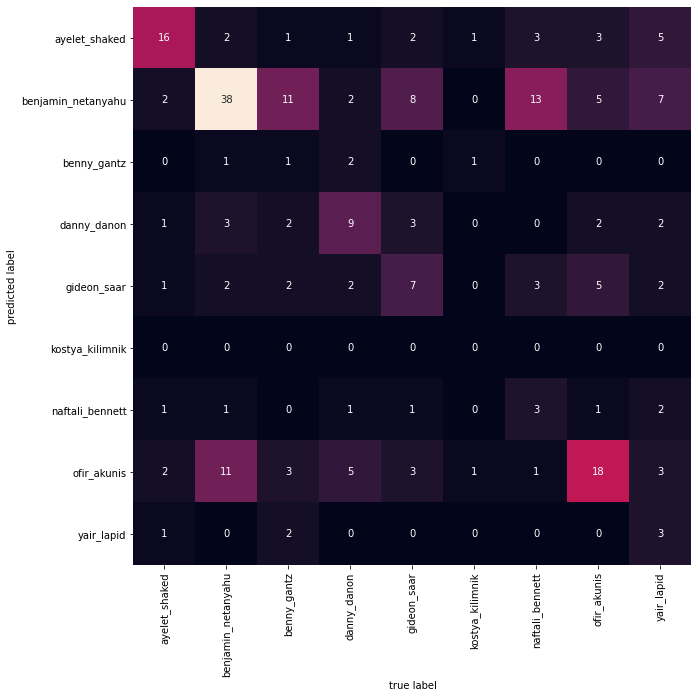

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(label_names, prediction_names)
classes_names = dataloaders[phase].dataset.classes
plt.figure(figsize = (10,13))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('true label')
plt.ylabel('predicted label');